<a href="https://colab.research.google.com/github/reinbugnot/movielens-recommender-system/blob/main/reco_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

from scipy.sparse import coo_matrix, vstack

from datetime import datetime

np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")
from tqdm.auto import tqdm

from random import sample

### Import Data

In [ ]:
# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-25m.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done!")

Done!


In [ ]:
# Import movies data
movies_data = pd.read_csv("./ml-25m/movies.csv")
genres_split = movies_data.genres.apply(lambda x: x.split(sep='|')).apply(pd.value_counts, 1).fillna(0)
movies_data = pd.concat([movies_data.iloc[:,:-1], genres_split], axis=1)
movies_data.shape
movies_data.head()

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Import ratings data
ratings_data = pd.read_csv("./ml-25m/ratings.csv")
ratings_data.timestamp = pd.to_datetime(ratings_data.timestamp, unit='s')
ratings_data.shape
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,2006-05-17 15:34:04
1,1,306,3.5,2006-05-17 12:26:57
2,1,307,5.0,2006-05-17 12:27:08
3,1,665,5.0,2006-05-17 15:13:40
4,1,899,3.5,2006-05-17 12:21:50


In [ ]:
# User Sampling
# Select 1/10 unique users from the original user pool due to memory limitations

print(f'There are {len(ratings_data)} rows in the original data from {len(ratings_data.userId.unique())} users')

rand_userIds = np.random.choice(ratings_data['userId'].unique(), size=int(len(ratings_data['userId'].unique())*0.1), replace=False)
ratings_data = ratings_data.loc[ratings_data['userId'].isin(rand_userIds)]

print(f'There are {len(ratings_data)} rows in the sampled data from {len(rand_userIds)} users')

There are 25000095 rows in the original data from 162541 users
There are 2503205 rows in the sampled data from 16254 users


In [ ]:
# Drop Movies without any user ratings
movies_data = movies_data[movies_data.movieId.isin(ratings_data.movieId)].reset_index(drop=True)
print(movies_data.shape)

(31646, 22)


### Data Cleaning

There are 1077.0 movies with invalid year data


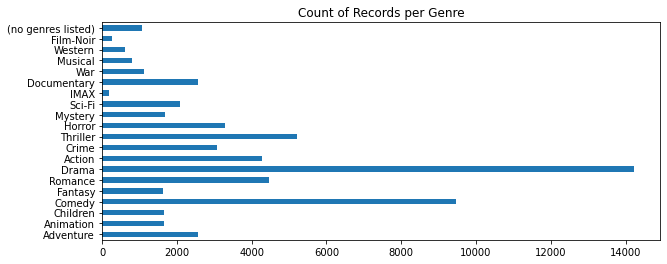

In [ ]:
plt.figure(figsize=(10,4))
movies_data.iloc[:, 2:].sum().plot.barh()
_=plt.title('Count of Records per Genre')

print(f"There are {movies_data['(no genres listed)'].sum()} movies with invalid year data")

In [ ]:
# Drop ratings with movies without genre listed
ratings_data = ratings_data[ratings_data.movieId.isin(movies_data[movies_data['(no genres listed)'] == 0].movieId)]

In [ ]:
# Extract year from movie title and add as new feature
# Any invalid year will be labelled '9999'

movies_data_year = movies_data.title.apply(lambda x: re.findall('\(([0-9]*)\)\s*$', x)[0] if len(re.findall('\(([0-9]*)\)\s*$', x)) > 0 else '9999')
movies_data['year'] = movies_data_year.astype('int64')

print(f'There are {(movies_data.year == 9999).sum()} movies with invalid year data')

There are 134 movies with invalid year data


In [ ]:
# Drop ratings with movies labelled with year 9999
ratings_data = ratings_data[ratings_data.movieId.isin(movies_data[movies_data.year != 9999].movieId)]

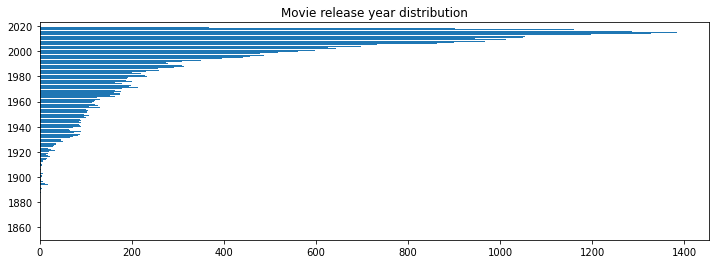

In [ ]:
plt.figure(figsize=(12,4))
plt.barh(movies_data.year.value_counts().index, movies_data.year.value_counts().values)
plt.ylim([1850,2023])
_=plt.title('Movie release year distribution')

In [ ]:
movies_data = movies_data[movies_data.year != 9999][movies_data['(no genres listed)'] == 0].reset_index(drop=True)
movies_data.drop(columns={'(no genres listed)'}, inplace=True)

In [ ]:
print(f'There are {len(ratings_data.movieId.unique())} movies in the ratings dataset')
print(f'There are {len(movies_data)} movies in the movies dataset')

There are 30516 movies in the ratings dataset
There are 30516 movies in the movies dataset


### Exploratory Data Analysis

In [ ]:
mean_ratings = ratings_data.groupby(['movieId'])['rating'].mean().reset_index().merge(movies_data.iloc[:,:2], on='movieId')
mean_ratings.columns = ['movieId', 'mean_rating', 'title']

count_ratings = ratings_data.movieId.value_counts().reset_index()
count_ratings.columns = ['movieId', 'count_rating']

ratings_aggr = mean_ratings.merge(count_ratings, on='movieId')
ratings_aggr

,movieId,mean_rating,title,count_rating
0,1,3.906575,Toy Story (1995),5673
1,2,3.251423,Jumanji (1995),2460
2,3,3.136477,Grumpier Old Men (1995),1198
3,4,2.957721,Waiting to Exhale (1995),272
4,5,3.014856,Father of the Bride Part II (1995),1178
...,...,...,...,...
30511,208765,5.000000,Picture a Perfect Christmas (2019),1
30512,208800,3.500000,Lady and the Tramp (2019),1
30513,208843,2.500000,An Acceptable Loss (2019),1
30514,209085,5.000000,The Mistletoe Secret (2019),1


In [ ]:
ratings_aggr[ratings_aggr.count_rating > 10].sort_values('mean_rating', ascending=False)

,movieId,mean_rating,title,count_rating
22817,147328,4.571429,The Adventures of Sherlock Holmes and Dr. Wats...,14
26031,171011,4.556122,Planet Earth II (2016),98
24376,159817,4.533133,Planet Earth (2006),166
9434,32853,4.500000,"Sorrow and the Pity, The (Le chagrin et la pit...",13
17492,107408,4.500000,Only Old Men Are Going to Battle (V boy idut o...,11
...,...,...,...,...
6213,6483,1.079545,From Justin to Kelly (2003),44
5506,5738,1.000000,Faces of Death 5 (1996),15
4577,4775,1.000000,Glitter (2001),63
1714,1826,0.978723,Barney's Great Adventure (1998),47


### Data Preprocessing

<img src='https://www.statology.org/wp-content/uploads/2020/11/loocv4-768x834.png' width='200' height='250'>

**Leave-One-Out Methodology:** For each user, the model will be tested on the most recently rated movie, and trained on all of the movies rated prior to the most recent. 

In [ ]:
# Calcuate the recency ranking of each rating data
ratings_data['recency'] = ratings_data.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
ratings_data.head()

,userId,movieId,rating,timestamp,recency
2450,13,1,4.0,2010-02-03 19:06:10,261.0
2451,13,19,3.5,2009-03-26 21:39:22,310.0
2452,13,32,4.0,2009-03-25 08:34:05,399.0
2453,13,34,4.0,2010-02-03 19:07:23,253.0
2454,13,47,4.0,2010-02-03 19:06:46,258.0


In [ ]:
# Train-test Split using leave-one-out methodology
ratings_data_test = ratings_data[ratings_data.recency == 1][['userId', 'movieId', 'rating', 'recency']]
ratings_data_train = ratings_data[ratings_data.recency != 1][['userId', 'movieId', 'rating']]

# Merge movies data to add content-based features to the input vectors
# ratings_data_train = ratings_data_train.merge(movies_data.loc[:, movies_data.columns != 'title'], on='movieId')
# ratings_data_test = ratings_data_test.merge(movies_data.loc[:, movies_data.columns != 'title'], on='movieId')

In [ ]:
ratings_data_test.head()

,userId,movieId,rating,recency
2855,13,87306,3.5,1.0
3785,21,51255,3.5,1.0
4335,25,509,5.0,1.0
6376,45,861,4.0,1.0
11803,85,263,4.0,1.0


Convert **Explicit Feedback** ratings data to **Implicit Feedback** by converting the *rating* metric (0 to 5) to *interacted* metric (0 or 1). We will then create a model that predicts the probability that a given user will interact with a movie/item (which can represent clicking on a thumbnail, searching for a movie, watching the movie, etc.) instead of predicting what rating a user will give a movie.

In [ ]:
# Move target column to last column index
# Convert explicit feedback to implicit feedback

col = ratings_data_train.pop('rating')
ratings_data_train = pd.concat([ratings_data_train, col], axis=1)

col = ratings_data_test.pop('rating')
ratings_data_test = pd.concat([ratings_data_test, col], axis=1)

ratings_data_train.rename(columns={'rating':'interacted'})
ratings_data_test.rename(columns={'rating':'interacted'})

ratings_data_train.loc[:, 'interacted'] = 1
ratings_data_test.loc[:, 'interacted'] = 1

ratings_data_test.drop(columns={'recency'}, inplace=True)
ratings_data_test.drop(columns={'rating'}, inplace=True)
ratings_data_train.drop(columns={'rating'}, inplace=True)

In [ ]:
# Final Training Data
print(f'Shape of training data: {ratings_data_train.shape} \n')
ratings_data_train.head()

Shape of training data: (2483622, 3) 



,userId,movieId,interacted
2450,13,1,1
2451,13,19,1
2452,13,32,1
2453,13,34,1
2454,13,47,1


### Pre-Model Transformations

**Basic NCF Architecture** [2]

<img src="https://i.ibb.co/m869ZFR/Recommender-System-Architecture.png"  width="60%" height="30%">

In [ ]:
# Create a lookup table where each column represent a movie genre and the indices represent corresponding feature encoding for each genre combination
movie_features_lookup = movies_data.iloc[:, 2:-1].drop_duplicates().reset_index(drop=True)
movie_features_lookup

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1408,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1409,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Convert to np array for faster execution
movie_features_lookup = movie_features_lookup.values

In [ ]:
def encode_movie_features(movie_feature, movie_features_lookup = movie_features_lookup):
  return np.where(np.all(movie_features_lookup == movie_feature, axis=1))[0][0]

In [ ]:
# All unique movies in the dataset
all_movieIds = movies_data['movieId'].unique()

**Generate Negative Samples**: All of our ratings data represent positive samples (i.e., movies the user has interacted with), we need to generate negative samples for the model as well.

In [ ]:
# Series containing all the movies interacted by each user.
user_interactions = ratings_data_train.groupby('userId')['movieId'].apply(list)
user_interactions

userId
13        [1, 19, 32, 34, 47, 60, 70, 104, 110, 112, 141...
21        [260, 293, 318, 527, 541, 589, 741, 750, 778, ...
25        [16, 17, 19, 21, 25, 36, 39, 47, 50, 52, 110, ...
45        [82, 83, 125, 140, 141, 150, 296, 380, 562, 59...
85        [7, 11, 17, 19, 21, 25, 34, 39, 74, 105, 141, ...
                                ...                        
162469    [110, 260, 318, 356, 527, 589, 1036, 1196, 119...
162511    [1088, 1197, 1680, 2145, 2161, 2193, 2248, 310...
162523    [252, 296, 370, 466, 543, 832, 1028, 1080, 137...
162532    [260, 296, 541, 1021, 1036, 1136, 1196, 1197, ...
162536    [50, 296, 318, 1089, 1208, 1222, 2959, 3535, 3...
Name: movieId, Length: 16254, dtype: object

In [ ]:
# Series containing all the movies NOT interacted by each user.
neg_user_interactions = []
num_negatives = 3

for u in tqdm(ratings_data_train.userId.unique()):

    # Negative Samples
    negative_samples = np.random.choice(list(set(all_movieIds) - set(user_interactions[u])), size=len(user_interactions[u]) * num_negatives)
    neg_user_interactions.append(negative_samples)
    
neg_user_interactions = pd.Series(neg_user_interactions)
neg_user_interactions.index = user_interactions.index

  0%|          | 0/16254 [00:00<?, ?it/s]

In [ ]:
neg_user_interactions

userId
13        [72386, 142821, 193761, 116539, 158613, 113705...
21        [144786, 74740, 165103, 5051, 79010, 139620, 8...
25        [169248, 174703, 44861, 176171, 2724, 203381, ...
45        [170887, 8667, 109576, 161153, 74698, 80405, 1...
85        [152656, 1289, 175937, 154911, 7241, 66295, 36...
                                ...                        
162469    [81411, 1504, 69387, 2128, 166906, 60579, 1776...
162511    [174607, 36083, 70742, 86773, 5474, 6651, 1392...
162523    [112625, 8924, 1422, 174601, 152916, 117434, 9...
162532    [104480, 908, 174745, 173941, 121129, 69072, 1...
162536    [4468, 37475, 143511, 42002, 88382, 33896, 195...
Length: 16254, dtype: object

In [ ]:
"""
Generate Dataset (sample):
users - User features (userId)
items - Item features
      - Selected item feature for this project are feature encodings based on movie genres.
label - Whether user interacted with the corresponding user or not
"""

users, items, labels = [], [], []

for u in tqdm(ratings_data_train.userId.unique()[:1000]):

    users.extend([u] * (len(user_interactions[u]) + len(neg_user_interactions[u])))
    
    user_interacted_movie_features = movies_data.set_index('movieId').loc[user_interactions[u]].iloc[:, 1:-1].values
    neg_user_interacted_movie_features = movies_data.set_index('movieId').loc[neg_user_interactions[u]].iloc[:, 1:-1].values

    items.extend(np.apply_along_axis(encode_movie_features, 1, user_interacted_movie_features).tolist())
    items.extend(np.apply_along_axis(encode_movie_features, 1, neg_user_interacted_movie_features).tolist())
    
    labels.extend([1] * len(user_interactions[u]))
    labels.extend([0] * len(neg_user_interactions[u]))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(f"Length of user list (sample): {len(users)}")
print(f"Length of item list (sample): {len(items)}")
print(f"Length of label list (sample): {len(labels)}")

Length of user list (sample): 600632
Length of item list (sample): 600632
Length of label list (sample): 600632


In [ ]:
# Item list containing encoded movie genre features
print(items[:10])

[0, 4, 21, 19, 29, 1, 39, 4, 50, 52]


In [ ]:
# Free up memory
del users, items, labels

### Build Model

In [ ]:
import torch
from torch.utils.data import Dataset

class MovieLensTrainDataset(Dataset):
    
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings_data, user_interactions, neg_user_interactions):
        self.users, self.items, self.labels = self.get_dataset(ratings_data, user_interactions, neg_user_interactions)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings_data, user_interactions, neg_user_interactions):
        users, items, labels = [], [], []

        for u in tqdm(ratings_data.userId.unique()):

            users.extend([u] * (len(user_interactions[u]) + len(neg_user_interactions[u])))
            
            user_interacted_movie_features = movies_data.set_index('movieId').loc[user_interactions[u]].iloc[:, 1:-1].values
            neg_user_interacted_movie_features = movies_data.set_index('movieId').loc[neg_user_interactions[u]].iloc[:, 1:-1].values

            items.extend(np.apply_along_axis(encode_movie_features, 1, user_interacted_movie_features).tolist())
            items.extend(np.apply_along_axis(encode_movie_features, 1, neg_user_interacted_movie_features).tolist())
            
            labels.extend([1] * len(user_interactions[u]))
            labels.extend([0] * len(neg_user_interactions[u]))

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [ ]:
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class NCF(pl.LightningModule):
    
    def __init__(self, num_users, num_items, ratings_data, user_interactions, neg_user_interactions):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings_data = ratings_data
        self.user_interactions = user_interactions
        self.neg_user_interactions = neg_user_interactions
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings_data, self.user_interactions, self.neg_user_interactions),
                          batch_size=512, num_workers=4)

### Train Model

In [ ]:
num_users = ratings_data['userId'].max()+1
num_items = movie_features_lookup.shape[0]

# Instantiate model object / Load Data
model = NCF(num_users, num_items, ratings_data_train, user_interactions, neg_user_interactions)

In [ ]:
# Train model
trainer = pl.Trainer(max_epochs=3, devices=1, accelerator="gpu", logger=False)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 1.3 M 
1 | item_embedding | Embedding | 11.3 K
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.259     Total estimated model params size (MB)


  0%|          | 0/16254 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


### Evaluate Model

In [ ]:
# Generate Interaction Data for Testing
user_interactions_test = ratings_data.groupby('userId')['movieId'].apply(list) # list of all movies the user has interacted with (both train and test)

neg_user_interactions_test = []

user_sample_test = sample(list(ratings_data_test.userId.unique()), 1000)

for u in tqdm(user_sample_test):

    # Negative Samples
    negative_samples = sample(list(set(all_movieIds) - set(user_interactions_test[u])), 99)
    neg_user_interactions_test.append(negative_samples)
    
neg_user_interactions_test = pd.Series(neg_user_interactions_test)
neg_user_interactions_test.index = user_sample_test

  0%|          | 0/1000 [00:00<?, ?it/s]

Testing methodology: **HR@10** (Hit Ratio at 10) [1] <br>
1. For each user, randomly select 99 items that the user has not interacted with.
2. Combine these 99 items with the test item (the actual item that the user last interacted with). We now have 100 items.
Run the model on these 100 items, and rank them according to their predicted probabilities.
3. Select the top 10 items from the list of 100 items. If the test item is present within the top 10 items, then we say that this is a hit.
4. Repeat the process for all users. The Hit Ratio is then the average hits.

In [ ]:
# Implement HR@10
hits = []
for (u, neg_interacted_items) in zip(neg_user_interactions_test.index, neg_user_interactions_test):
    
    interacted_item = ratings_data_test[ratings_data_test.userId == u].movieId.values[0]
    
    test_items = [interacted_item] + list(neg_interacted_items)

    # Movie IDs to Movie Features
    test_items_features = movies_data[movies_data.movieId.isin(test_items)].iloc[:, 2:-1].values

    # Movie Features to Movie Feature Encoding
    test_items_features_encodings = np.apply_along_axis(encode_movie_features, 1, test_items_features)

    predicted_labels = np.squeeze(model(torch.tensor([u]*100), torch.tensor(test_items_features_encodings)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[-10:]]

    if interacted_item in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

The Hit Ratio @ 10 is 0.20


In [ ]:
print(f'Item interacted by the user: {movies_data[movies_data.movieId == interacted_item].title.values[0]}')

Item interacted by the user: Kill Bill: Vol. 1 (2003)


### Check test movies and results

In [ ]:
movies_data[movies_data.movieId == interacted_item].loc[:, (movies_data[movies_data.movieId == interacted_item] != 0).any(axis=0)]

,movieId,title,Action,Crime,Thriller,year
6582,6874,Kill Bill: Vol. 1 (2003),1.0,1.0,1.0,2003


In [ ]:
print('Top 10 recommended items: \n')
movies_data[movies_data.movieId.isin(top10_items)].loc[:, (movies_data[movies_data.movieId.isin(top10_items)] != 0).any(axis=0)]

Top 10 recommended items: 



,movieId,title,Adventure,Comedy,Romance,Drama,Action,Thriller,Western,year
2790,2921,High Plains Drifter (1973),0.0,0.0,0.0,0.0,0.0,0.0,1.0,1973
5739,5986,Fat City (1972),0.0,0.0,0.0,1.0,0.0,0.0,0.0,1972
6494,6783,"Rules of the Game, The (La règle du jeu) (1939)",0.0,1.0,0.0,1.0,0.0,0.0,0.0,1939
6862,7169,Chasing Liberty (2004),0.0,1.0,1.0,0.0,0.0,0.0,0.0,2004
9042,27888,When Will I Be Loved (2004),0.0,0.0,0.0,1.0,0.0,0.0,0.0,2004
11502,57854,The Count of Monte Cristo (1934),1.0,0.0,1.0,1.0,1.0,1.0,0.0,1934
12623,69753,Pittsburgh (1942),0.0,0.0,0.0,1.0,0.0,0.0,0.0,1942
18378,114898,Millie (1931),0.0,0.0,1.0,1.0,0.0,0.0,0.0,1931
24936,164153,Born Equal (2006),0.0,0.0,0.0,1.0,0.0,0.0,0.0,2006
26173,171729,The Best Movie (2008),0.0,1.0,0.0,0.0,0.0,0.0,0.0,2008


### References:

1. [Loy, James, "Deep Learning based Recommender Systems"](https://towardsdatascience.com/deep-learning-based-recommender-systems-3d120201db7e)

2. [He, et. al, "Neural Collaborative Filtering](https://arxiv.org/abs/1708.05031)